# Measures of error in optic flow methods

Running deepflow_refframes.py on a video and specified set of reference frames will run DeepMatching to find a set of good correspondence points between each pair of ref frames. It will then run DeepFlow using these correspondences to seed/constrain the estimation. It also runs MFSF multi-frame optic flow between consecutive reference frames. 

Here we play around with the quality of the MFSF between consec. ref frames.

In [7]:
%matplotlib inline
import sys 
import argparse 
import os.path 
import os

import numpy as np 
from glob import glob 

from cvtools import readFlo

import matplotlib.pyplot as plt
import cv2 
from scipy.io import loadmat 

threshold = 4
radius = 6

class Args:
	pass 
args = Args()

### Hydra data

In [9]:
args.dir_in = './register/20160412stk0001/'

#Get the set of reference frames...
refframes = [int(i[-8:-4]) for i in glob(args.dir_in + 'refframes/*.png')]
nF = len(refframes)
refframes = sorted(refframes)

threshold = 4
radius = 6

In [10]:
idx = 0;

r1 = refframes[idx]
r2 = refframes[idx+1]
print("Load MFSF results between ref frames %d and %d" %(r1, r2))
fn_in1 = args.dir_in + 'mfsf/ref_%d/result.mat'%(r1)
fn_in2 = args.dir_in + 'mfsf/ref_%d/result.mat'%(r2)

#flow1 = readFlo(fn_in1)
#flow2 = readFlo(fn_in2)

#Load MFSF data
a = loadmat(fn_in1)				
params = a['parmsOF']
u = a['u']
v = a['v']
nx = u.shape[0]
ny = u.shape[1]
flow1 = np.zeros((nx, ny, 2))
flow1[:,:,0] = u[:,:,-1]
flow1[:,:,1] = v[:,:,-1]

a = loadmat(fn_in2)				
params = a['parmsOF']
u = a['u']
v = a['v']
flow2 = np.zeros((nx, ny, 2))
flow2[:,:,0] = u[:,:,0]
flow2[:,:,1] = v[:,:,0]

#Flip x and y flow
#flow1 = np.transpose(flow1, [1,0,2])
#flow2 = np.transpose(flow2, [1,0,2])
#flow1 = flow1[:,:,::-1]
#flow2 = flow2[:,:,::-1]

#Perform mapping and then reverse mapping, then perform reverse mapping then mapping
#Make mesh grid
fwdmeshy, fwdmeshx = [a.astype(np.float32) for a in np.meshgrid(np.arange(nx), np.arange(ny))]
revmeshy, revmeshx = [a.astype(np.float32) for a in np.meshgrid(np.arange(nx), np.arange(ny))]

#Perturb mesh grid by forward flow 
#Round to integers 
fwdx = fwdmeshx + np.ceil(flow1[:,:,0])
fwdy = fwdmeshy + np.ceil(flow1[:,:,1])

fwdx = np.maximum(0, np.minimum(nx-1, fwdx))
fwdy = np.maximum(0, np.minimum(nx-1, fwdy))

#Look up flow field using this perturbed map
fwdremapx = fwdx + flow2[fwdx.astype(int),fwdy.astype(int),0]
fwdremapy = fwdy + flow2[fwdx.astype(int),fwdy.astype(int),1]

fwdremapx -= fwdmeshx 
fwdremapy -= fwdmeshy 

fwderr = np.sqrt(fwdremapx**2 + fwdremapy**2)

#Determine based on absolute value of displacement whether 'mapped' or not...
#perhaps model as GMM/some sort of smoothing....
#plt.pcolor(fwderr)
#plt.colorbar()
#plt.show()

#Plot flow data 
#absflow1 = np.sqrt(flow1[:,:,0]**2 + flow1[:,:,1]**2)
#absflow2 = np.sqrt(flow2[:,:,0]**2 + flow2[:,:,1]**2)

#Load reference frame
fn_in1 = args.dir_in + 'refframes/frame_%04d.tif'%r1
rf1 = cv2.imread(fn_in1)
fn_in2 = args.dir_in + 'refframes/frame_%04d.tif'%r2
rf2 = cv2.imread(fn_in2)


Load MFSF results between ref frames 1 and 40


First we perform the forward map, then the reverse map. We should get back to where we started. Thus large errors here indicate errors in the flow, or indicate difficult to specify parts of the image.

The forward and reverse flow maps are roughly inverses of one another...with noticeable errors near the border where there is no image information

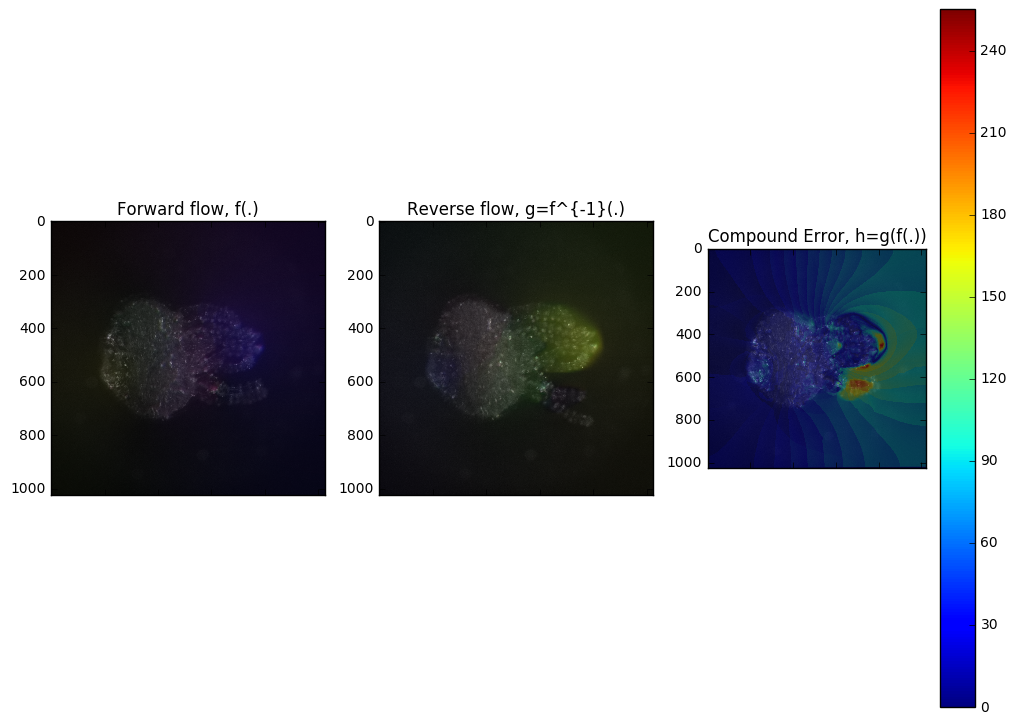

In [12]:
hsv = np.zeros_like(rf1)
hsv[...,1] = 255
mag, ang = cv2.cartToPolar(flow1[...,0], flow1[...,1])
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
bgr1 = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
dst1 = cv2.addWeighted(rf1,0.7,bgr1,0.3,0)

hsv = np.zeros_like(rf2)
hsv[...,1] = 255
mag, ang = cv2.cartToPolar(flow2[...,0], flow2[...,1])
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
bgr2 = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
dst2 = cv2.addWeighted(rf2,0.7,bgr2,0.3,0)

#Overlay with reference frame...
im_fwderr = cv2.normalize(fwderr, fwderr, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
im_fwderr = cv2.cvtColor(im_fwderr, cv2.COLOR_GRAY2BGR)
im_fwderr = cv2.applyColorMap(im_fwderr, cv2.COLORMAP_JET)
im_fwderr = cv2.cvtColor(im_fwderr, cv2.COLOR_BGR2RGB)
dst = cv2.addWeighted(rf1,0.7,im_fwderr,0.3,0)

fig_size = (12,9)
plt.rcParams["figure.figsize"] = fig_size

f, axes = plt.subplots(1,3)
p1 = axes[0].imshow(dst1)
p2 = axes[1].imshow(dst2)
p3 = axes[2].imshow(dst)
axes[0].set_title('Forward flow, f(.)')
axes[0].xaxis.set_ticklabels([])
axes[0].xaxis.set_ticklabels([])
axes[1].set_title('Reverse flow, g=f^{-1}(.)')
axes[1].xaxis.set_ticklabels([])
axes[1].xaxis.set_ticklabels([])
axes[2].set_title('Compound Error, h=g(f(.))')
axes[2].xaxis.set_ticklabels([])
axes[2].xaxis.set_ticklabels([])
plt.colorbar(p3)